In [ ]:
!pip install mne seaborn -q

import os
import numpy as np
import random

import mne
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from scipy.signal import welch

from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 21.3 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Path where SxxxR01.edf / SxxxR02.edf live
DATA_DIR = "/content/drive/MyDrive/eeg_eyes_project"  # change if needed

print("First 10 files in data dir:", os.listdir(DATA_DIR)[:10])

# Helper: find first subject that has BOTH R01 (open) and R02 (closed)
def find_subject_with_baseline(data_dir):
    for s in range(1, 51):
        f_open = os.path.join(data_dir, f"S{s:03d}R01.edf")
        f_closed = os.path.join(data_dir, f"S{s:03d}R02.edf")
        if os.path.exists(f_open) and os.path.exists(f_closed):
            return s, f_open, f_closed
    return None, None, None

subj_id, file_open, file_closed = find_subject_with_baseline(DATA_DIR)

if subj_id is None:
    raise RuntimeError("Did not find any subject with both R01 and R02.")

print(f"Using subject S{subj_id:03d}")
print("Open file:  ", os.path.basename(file_open))
print("Closed file:", os.path.basename(file_closed))


First 10 files in data dir: ['S001R01.edf', 'S001R02.edf', 'S002R01.edf', 'S002R02.edf', 'S003R01.edf', 'S003R02.edf', 'S004R01.edf', 'S004R02.edf', 'S005R01.edf', 'S005R02.edf']
Using subject S001
Open file:   S001R01.edf
Closed file: S001R02.edf


In [ ]:
def load_raw(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.pick_types(eeg=True)
    raw.set_eeg_reference('average', projection=False, verbose=False)
    return raw

raw_open = load_raw(file_open)
raw_closed = load_raw(file_closed)

print("Channel names:", raw_open.info["ch_names"])

# Prefer a CP or Cz channel if available
preferred = ["Cpz.", "Cp1.", "Cp2.", "Cz.", "Cp3.", "Cp4."]
ch_names = raw_open.info["ch_names"]
for name in preferred:
    if name in ch_names:
        channel = name
        break
else:
    channel = ch_names[0]  # fallback

print("Using channel for visuals:", channel)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Channel names: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
Using channel for visuals: Cpz.


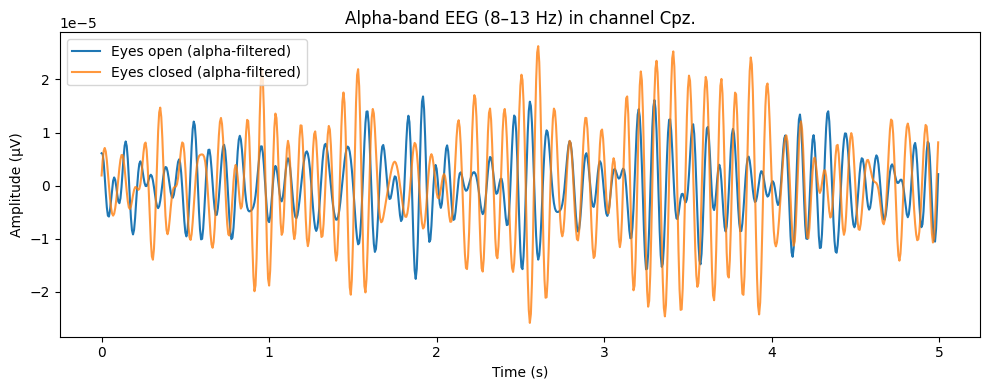

In [ ]:
# Make copies so we don't mess up the originals
raw_open_alpha = raw_open.copy().filter(8., 13., fir_design='firwin', verbose=False)
raw_closed_alpha = raw_closed.copy().filter(8., 13., fir_design='firwin', verbose=False)

sfreq = raw_open_alpha.info["sfreq"]
t_win = 5.0  # seconds to display
n_samp = int(t_win * sfreq)

# Take a segment starting 10s into each recording to avoid startup junk
start_sample = int(10 * sfreq)

data_open, times_open = raw_open_alpha[channel, start_sample:start_sample + n_samp]
data_closed, times_closed = raw_closed_alpha[channel, start_sample:start_sample + n_samp]

# Shift time axis to start at 0
times_open = times_open - times_open[0]
times_closed = times_closed - times_closed[0]

plt.figure(figsize=(10, 4))
plt.plot(times_open, data_open.T, label="Eyes open (alpha-filtered)")
plt.plot(times_closed, data_closed.T, label="Eyes closed (alpha-filtered)", alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title(f"Alpha-band EEG (8–13 Hz) in channel {channel}")
plt.legend()
plt.tight_layout()
plt.show()


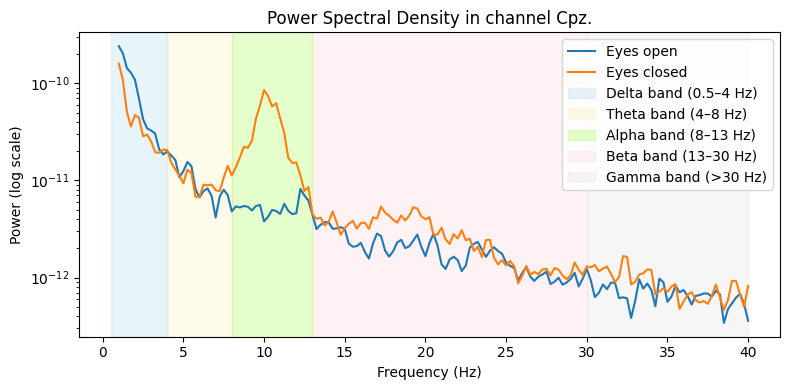

In [ ]:
def compute_psd(raw, channel, fmin=1., fmax=40.):
    data, _ = raw[channel, :]
    sfreq = raw.info["sfreq"]
    freqs, psd = welch(data[0], sfreq, nperseg=4*int(sfreq))  # ~4s windows
    mask = (freqs >= fmin) & (freqs <= fmax)
    return freqs[mask], psd[mask]

freqs_o, psd_o = compute_psd(raw_open, channel)
freqs_c, psd_c = compute_psd(raw_closed, channel)

plt.figure(figsize=(8, 4))
plt.semilogy(freqs_o, psd_o, label="Eyes open")
plt.semilogy(freqs_c, psd_c, label="Eyes closed")
# plt.semilogy(freqs_c, psd_c)
plt.axvspan(0.5, 4, color="skyblue", alpha=0.2, label="Delta band (0.5–4 Hz)")
plt.axvspan(4, 8, color="khaki", alpha=0.2, label="Theta band (4–8 Hz)")
plt.axvspan(8, 13, color="chartreuse", alpha=0.2, label="Alpha band (8–13 Hz)")
plt.axvspan(13, 30, color="pink", alpha=0.2, label="Beta band (13–30 Hz)")
plt.axvspan(30, 40, color="lightgray", alpha=0.2, label="Gamma band (>30 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (log scale)")
plt.title(f"Power Spectral Density in channel {channel}")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
